In [1]:
import matplotlib.pyplot as plt

import tensorflow as tf
import os
from model_params import *
from models import *
from dataTransformer import *
#tf.disable_v2_behavior()


%matplotlib inline
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
# Load the TensorBoard notebook extension.


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Loading data

In [3]:
DATA_ROOT = "asl_alphabet_train/"
batch_size = BATCH_SIZE
img_height,img_width,img_channels = IMG_DIM
OVERWRITE_MODEL = False
seed = 12353
validation_split = 0.2
AUTOTUNE = tf.data.AUTOTUNE
DO_TRANSFORM = True

In [4]:
train_ds,val_ds,test_ds,class_names = load_dataset(DATA_ROOT,seed=seed)
num_classes = len(class_names)

Found 87000 files belonging to 29 classes.
Using 52200 files for training.
Found 87000 files belonging to 29 classes.
Using 34800 files for validation.
Splitting validation into validation and test
Using 17400 files for validation and 17400 files for test


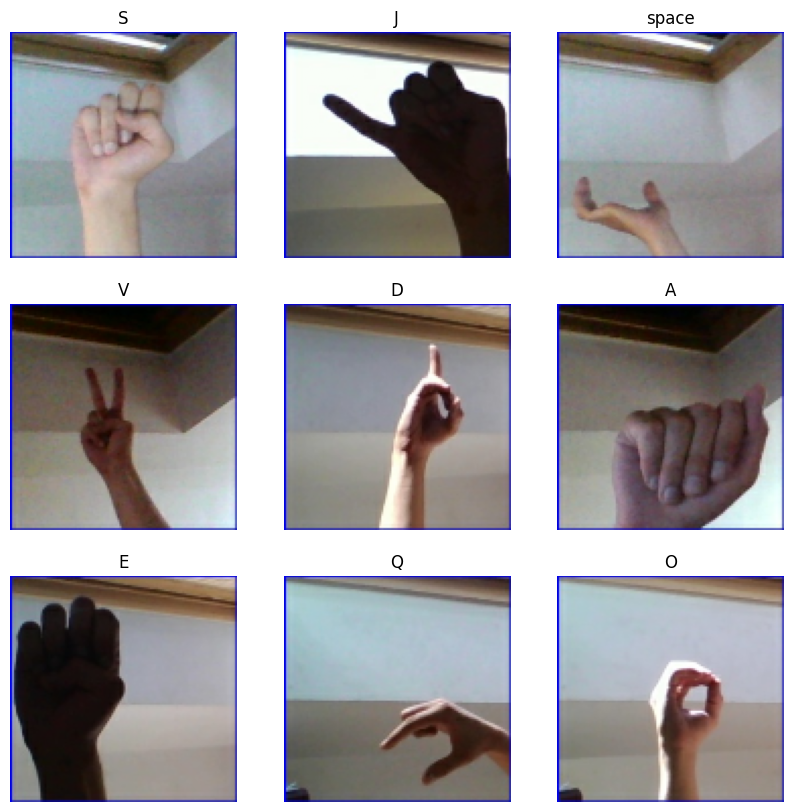

In [5]:
plt.figure(figsize=(10, 10))
for i, (img, label) in enumerate(train_ds.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(img.numpy())
  plt.title(class_names[label])
  plt.axis("off")

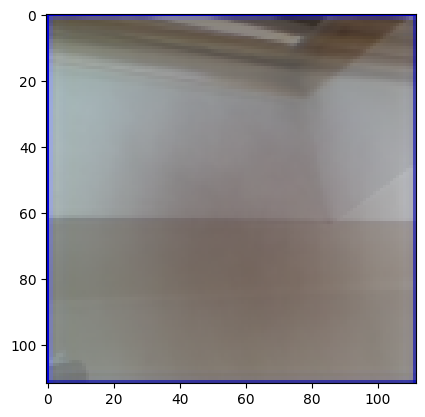

In [6]:
running_sum = tf.zeros(INPUT_SHAPE)

for img, lable in train_ds.take(1000):
    
    running_sum = running_sum+(img/1000.0)
plt.imshow(running_sum.numpy())

# Preprocessing

In [7]:
from dataTransformer import random_transformations

if DO_TRANSFORM:
    train_ds = train_ds.map(random_transformations, num_parallel_calls=AUTOTUNE)

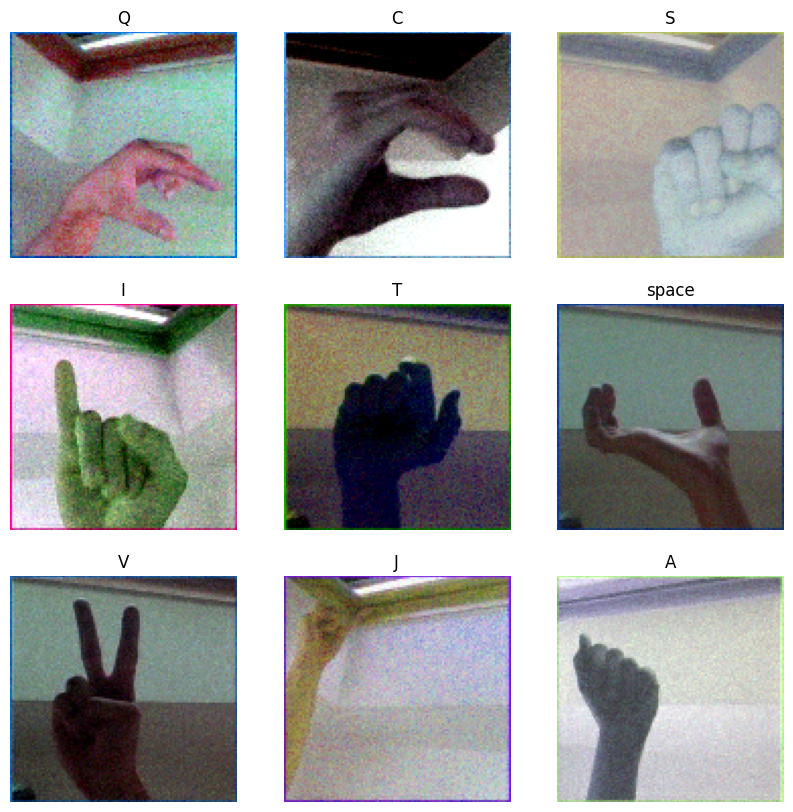

In [8]:
plt.figure(figsize=(10, 10))
for i, (img, label) in enumerate(train_ds.take(9)):
  
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(img.numpy())
  plt.title(class_names[label])
  plt.axis("off")

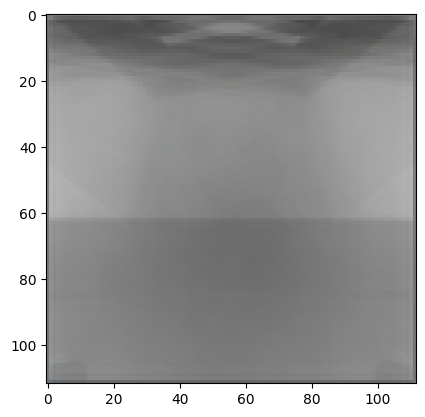

In [9]:
running_sum = tf.zeros(INPUT_SHAPE)
img_num = 0
for img, lable in train_ds.take(1000):
    running_sum = running_sum+((img)/1000.0)
plt.imshow(running_sum.numpy())

In [10]:
train_ds = train_ds.batch(batch_size,num_parallel_calls=AUTOTUNE).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

## Baseline model

Simple linear regression

In [11]:
lr_model = tf.keras.Sequential([
  tf.keras.layers.Resizing(INPUT_SHAPE[0]//2,INPUT_SHAPE[1]//2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(num_classes)
])

#using rms optimizer 
lr_model.compile(
  optimizer='rmsprop',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

lr_model.build([None,INPUT_SHAPE[0],INPUT_SHAPE[1],INPUT_SHAPE[2]])
lr_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 56, 56, 3)         0         
                                                                 
 flatten (Flatten)           (None, 9408)              0         
                                                                 
 dense (Dense)               (None, 29)                272861    
                                                                 
Total params: 272,861
Trainable params: 272,861
Non-trainable params: 0
_________________________________________________________________


In [12]:
model_backup_callback = tf.keras.callbacks.BackupAndRestore(
    backup_dir=BACKUP_FILEPATH+"/lr_model")

trained = False

if OVERWRITE_MODEL or not os.path.exists(MODEL_DIR+"/lr_model.keras"):
    
  history = lr_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=150,callbacks=[model_backup_callback]
  )
  trained = True
else:
  lr_model.load_weights(MODEL_DIR+"/lr_model.keras")



Epoch 1/150
1632/1632 [==============================] - 15s 8ms/step - loss: 7.5210 - accuracy: 0.0699 - val_loss: 7.5480 - val_accuracy: 0.0828
Epoch 2/150
1632/1632 [==============================] - 8s 5ms/step - loss: 6.8885 - accuracy: 0.0996 - val_loss: 7.7278 - val_accuracy: 0.0928
Epoch 3/150
1632/1632 [==============================] - 8s 5ms/step - loss: 6.5941 - accuracy: 0.1142 - val_loss: 12.6662 - val_accuracy: 0.0525
Epoch 4/150
1632/1632 [==============================] - 8s 5ms/step - loss: 6.3863 - accuracy: 0.1275 - val_loss: 8.1011 - val_accuracy: 0.1008
Epoch 5/150
1632/1632 [==============================] - 8s 5ms/step - loss: 6.2566 - accuracy: 0.1373 - val_loss: 9.4540 - val_accuracy: 0.1107
Epoch 6/150
1632/1632 [==============================] - 8s 5ms/step - loss: 6.1406 - accuracy: 0.1432 - val_loss: 8.2269 - val_accuracy: 0.1221
Epoch 7/150
1632/1632 [==============================] - 8s 5ms/step - loss: 6.0513 - accuracy: 0.1502 - val_loss: 6.9181 - val_

In [13]:
lr_res = evaluate_model(lr_model,test_ds,verbose=3,savePath=MODEL_DIR+"/lr_model.keras")

544/544 [==============================] - 5s 4ms/step - loss: 4.8469 - accuracy: 0.2587
Test loss: 4.846909999847412
Test accuracy: 0.25873562693595886
Model saved to models/lr_model.keras


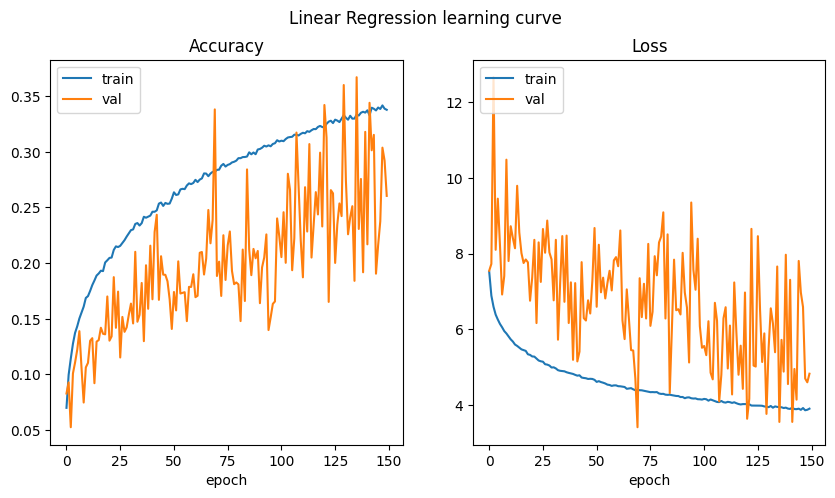

In [14]:
if trained:
    plot_curves(history, title="Linear Regression learning curve",save_fig=trained)

## Neural Network

In [15]:
nn_model = tf.keras.Sequential([
  tf.keras.layers.Resizing(INPUT_SHAPE[0]//2,INPUT_SHAPE[1]//2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256),
  tf.keras.layers.Normalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dense(256),
  tf.keras.layers.Normalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dense(256),
  tf.keras.layers.Normalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dense(num_classes)
])
nn_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
nn_model.build([None,*INPUT_SHAPE])
nn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 56, 56, 3)         0         
                                                                 
 flatten_1 (Flatten)         (None, 9408)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               2408704   
                                                                 
 normalization (Normalizatio  (None, 256)              513       
 n)                                                              
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                      

In [16]:
model_backup_callback = tf.keras.callbacks.BackupAndRestore(
    backup_dir=BACKUP_FILEPATH+"/nn_model")
trained = False
if OVERWRITE_MODEL or not os.path.exists(MODEL_DIR+"/nn_model.keras"):
    
  history = nn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=75,callbacks=[model_backup_callback]
  )
  trained = True
else:
  nn_model.load_weights(MODEL_DIR+"/nn_model.keras")

Epoch 1/75
1632/1632 [==============================] - 11s 6ms/step - loss: 3.1098 - accuracy: 0.0902 - val_loss: 2.8736 - val_accuracy: 0.1236
Epoch 2/75
1632/1632 [==============================] - 10s 6ms/step - loss: 2.8330 - accuracy: 0.1327 - val_loss: 2.6688 - val_accuracy: 0.1652
Epoch 3/75
1632/1632 [==============================] - 10s 6ms/step - loss: 2.7172 - accuracy: 0.1575 - val_loss: 2.5450 - val_accuracy: 0.2030
Epoch 4/75
1632/1632 [==============================] - 10s 6ms/step - loss: 2.6484 - accuracy: 0.1751 - val_loss: 2.4615 - val_accuracy: 0.2195
Epoch 5/75
1632/1632 [==============================] - 10s 6ms/step - loss: 2.5494 - accuracy: 0.1967 - val_loss: 2.3446 - val_accuracy: 0.2479
Epoch 6/75
1632/1632 [==============================] - 10s 6ms/step - loss: 2.4828 - accuracy: 0.2115 - val_loss: 2.4702 - val_accuracy: 0.2100
Epoch 7/75
1632/1632 [==============================] - 10s 6ms/step - loss: 2.4317 - accuracy: 0.2221 - val_loss: 2.2393 - val_ac

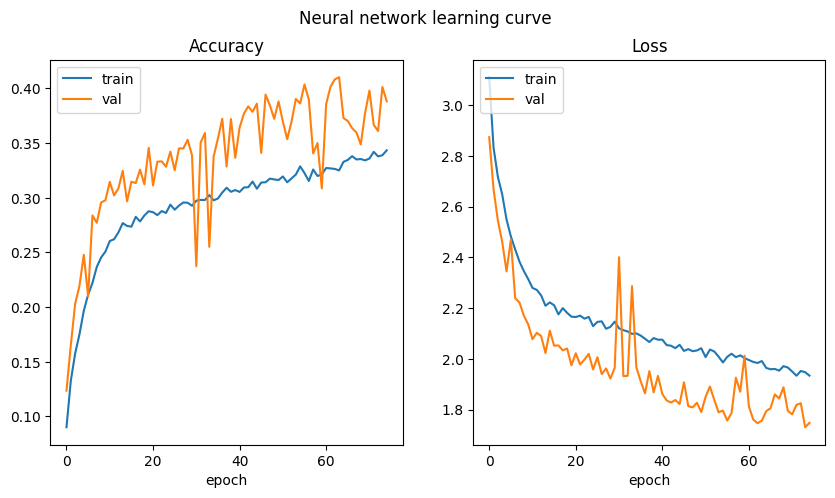

In [17]:
plot_curves(history, title="Neural network learning curve",save_fig=trained)

In [18]:
nn_model_res = evaluate_model(nn_model,test_ds,verbose=3,savePath=MODEL_DIR+"/nn_model.keras")

544/544 [==============================] - 2s 3ms/step - loss: 1.7378 - accuracy: 0.3909
Test loss: 1.7377725839614868
Test accuracy: 0.3909195363521576
Model saved to models/nn_model.keras


# CNN

In [19]:
simple_cnn_model = tf.keras.Sequential([
  
  tf.keras.layers.Conv2D(32, 7,padding='same',strides=2),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPooling2D(2),

  tf.keras.layers.Conv2D(64, 5,padding='same',strides=1),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPooling2D(2),

  tf.keras.layers.Conv2D(128, 3,padding='same',strides=1),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.MaxPooling2D(2),
  
  
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(num_classes)
])
simple_cnn_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
simple_cnn_model.build([None,*INPUT_SHAPE])
simple_cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 32)        4736      
                                                                 
 batch_normalization (BatchN  (None, 56, 56, 32)       128       
 ormalization)                                                   
                                                                 
 activation_3 (Activation)   (None, 56, 56, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 64)      

In [20]:


model_backup_callback = tf.keras.callbacks.BackupAndRestore(backup_dir=BACKUP_FILEPATH+"/simple_cnn_model")

trained = False

if OVERWRITE_MODEL or not os.path.exists(MODEL_DIR+"/simple_cnn_model.keras"):
  
  history = simple_cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[model_backup_callback]
  )
  trained = True
else:
  simple_cnn_model.load_weights(MODEL_DIR+"/simple_cnn_model.keras")

Epoch 1/50
1632/1632 [==============================] - 15s 7ms/step - loss: 2.0596 - accuracy: 0.4278 - val_loss: 1.6452 - val_accuracy: 0.5344
Epoch 2/50
1632/1632 [==============================] - 11s 7ms/step - loss: 0.5500 - accuracy: 0.8325 - val_loss: 0.4644 - val_accuracy: 0.8507
Epoch 3/50
1632/1632 [==============================] - 11s 7ms/step - loss: 0.2574 - accuracy: 0.9201 - val_loss: 0.5064 - val_accuracy: 0.8336
Epoch 4/50
1632/1632 [==============================] - 11s 7ms/step - loss: 0.1574 - accuracy: 0.9525 - val_loss: 0.5185 - val_accuracy: 0.8404
Epoch 5/50
1632/1632 [==============================] - 11s 7ms/step - loss: 0.1064 - accuracy: 0.9674 - val_loss: 0.3865 - val_accuracy: 0.8833
Epoch 6/50
1632/1632 [==============================] - 11s 7ms/step - loss: 0.0847 - accuracy: 0.9752 - val_loss: 0.0808 - val_accuracy: 0.9736
Epoch 7/50
1632/1632 [==============================] - 11s 7ms/step - loss: 0.0634 - accuracy: 0.9811 - val_loss: 0.1880 - val_ac

In [21]:
cnn_model_res = evaluate_model(simple_cnn_model,test_ds,verbose=3,savePath=MODEL_DIR+"/simple_cnn_model.keras")

544/544 [==============================] - 2s 3ms/step - loss: 0.0135 - accuracy: 0.9961
Test loss: 0.013516876846551895
Test accuracy: 0.9960919618606567
Model saved to models/simple_cnn_model.keras


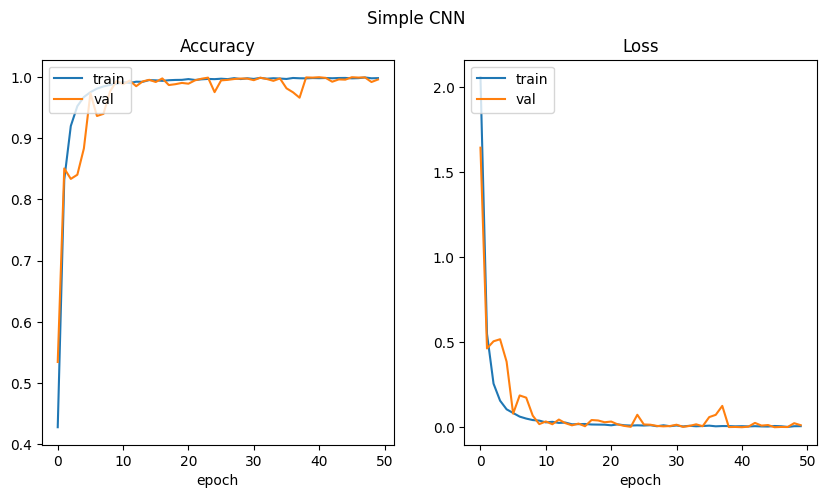

In [22]:
plot_curves(history, title="Simple CNN",save_fig=trained)

## CNN - 12-layer Resnet

In [23]:
from dataTransformer import *

resnet_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 7,padding='same',strides=2),#56x56
  ResnetBlock(5,filt=64,filt_in=32,num=2,stride=2),#28x28
  ResnetBlock(5,filt=64,filt_in=64,num=2),

  ResnetBlock(3,filt=128,filt_in=64,num=2,stride=2),#14x14
  ResnetBlock(3,filt=128,filt_in=128,num=2),

  ResnetBlock(3,filt=256,filt_in=128,num=2,stride=2),#7x7
  ResnetBlock(3,filt=256,filt_in=256,num=2),

  tf.keras.layers.AveragePooling2D(7),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(num_classes)
])
resnet_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
resnet_model.build([None,*INPUT_SHAPE])
resnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 56, 56, 32)        4736      
                                                                 
 resnet_block (ResnetBlock)  (None, 28, 28, 64)        205760    
                                                                 
 resnet_block_1 (ResnetBlock  (None, 28, 28, 64)       205440    
 )                                                               
                                                                 
 resnet_block_2 (ResnetBlock  (None, 14, 14, 128)      296832    
 )                                                               
                                                                 
 resnet_block_3 (ResnetBlock  (None, 14, 14, 128)      296192    
 )                                                               
                                                      

In [24]:
model_backup_callback = tf.keras.callbacks.BackupAndRestore(
    backup_dir=BACKUP_FILEPATH+"/resnet_model")

trained = False

if OVERWRITE_MODEL or not os.path.exists(MODEL_DIR+"/resnet_model.keras"):
  
  history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[model_backup_callback]
  )
  trained = True
else:
  resnet_model.load_weights(MODEL_DIR+"/resnet_model.keras")

Epoch 1/25
1632/1632 [==============================] - 31s 17ms/step - loss: 0.8532 - accuracy: 0.7446 - val_loss: 0.2301 - val_accuracy: 0.9195
Epoch 2/25
1632/1632 [==============================] - 27s 16ms/step - loss: 0.1050 - accuracy: 0.9674 - val_loss: 0.5279 - val_accuracy: 0.8420
Epoch 3/25
1632/1632 [==============================] - 26s 16ms/step - loss: 0.0602 - accuracy: 0.9811 - val_loss: 0.1856 - val_accuracy: 0.9447
Epoch 4/25
1632/1632 [==============================] - 27s 16ms/step - loss: 0.0456 - accuracy: 0.9861 - val_loss: 0.0739 - val_accuracy: 0.9768
Epoch 5/25
1632/1632 [==============================] - 27s 16ms/step - loss: 0.0345 - accuracy: 0.9894 - val_loss: 0.0218 - val_accuracy: 0.9928
Epoch 6/25
1632/1632 [==============================] - 27s 17ms/step - loss: 0.0308 - accuracy: 0.9906 - val_loss: 0.0678 - val_accuracy: 0.9772
Epoch 7/25
1632/1632 [==============================] - 27s 17ms/step - loss: 0.0198 - accuracy: 0.9938 - val_loss: 0.0070 -

In [25]:
resnet_model_res = evaluate_model(resnet_model,test_ds,verbose=3,savePath=MODEL_DIR+"/resnet_model.keras")

544/544 [==============================] - 3s 6ms/step - loss: 0.0070 - accuracy: 0.9978
Test loss: 0.007040673401206732
Test accuracy: 0.9977586269378662
Model saved to models/resnet_model.keras


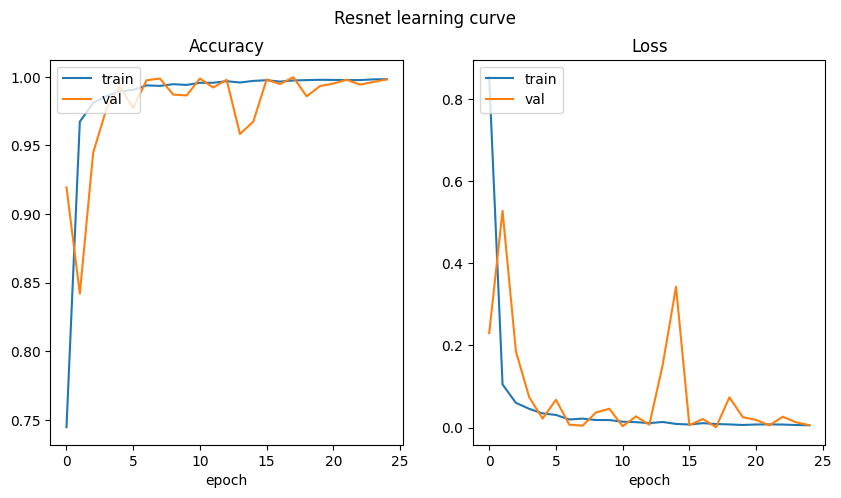

In [26]:
plot_curves(history,title="Resnet learning curve",save_fig=trained)

## Comparison

tf.Tensor([ 3  6 14 ... 26  1 10], shape=(17400,), dtype=int32)


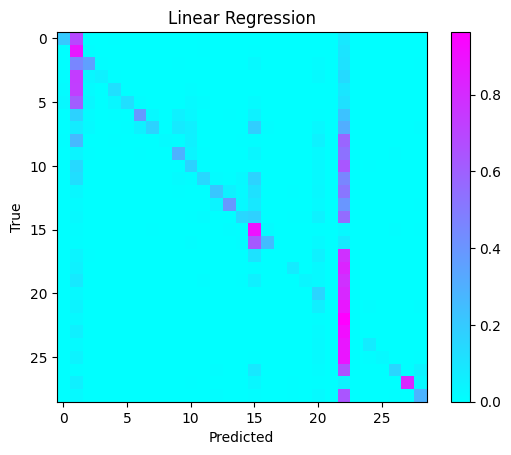

In [27]:
from dataTransformer import *
confusion_matrix(lr_model,test_ds,class_names,title="Linear Regression",save_fig=True)

tf.Tensor([ 3  6 14 ... 26  1 10], shape=(17400,), dtype=int32)


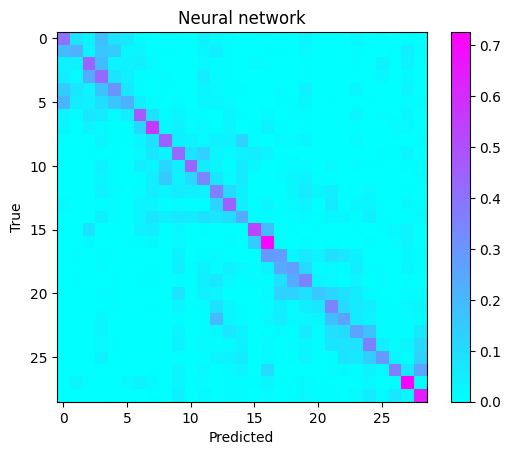

In [28]:
confusion_matrix(nn_model,test_ds,class_names,title="Neural network",save_fig=True)

tf.Tensor([ 3  6 14 ... 26  1 10], shape=(17400,), dtype=int32)


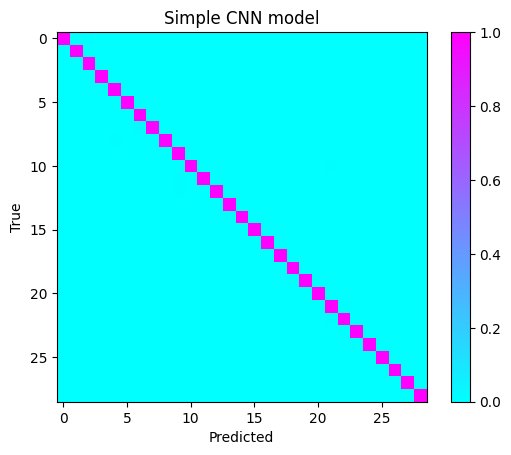

In [29]:
confusion_matrix(simple_cnn_model,test_ds,class_names,title="Simple CNN model",save_fig=True)

tf.Tensor([ 3  6 14 ... 26  1 10], shape=(17400,), dtype=int32)


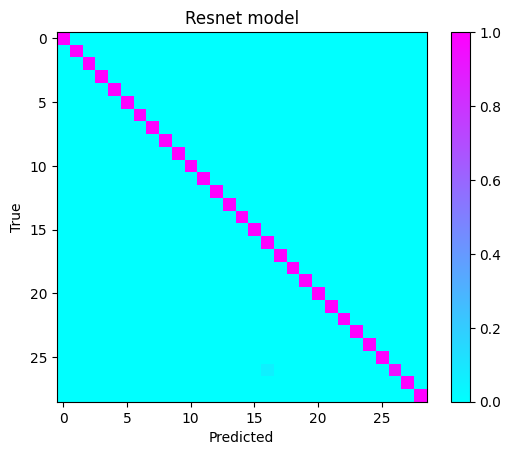

In [30]:
confusion_matrix(resnet_model,test_ds,class_names,title="Resnet model",save_fig=True)